<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/review_processing_2020_02_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [3]:
!pip install -U spacy[cuda100]

     |████████████████████████████████| 10.4MB 3.3MB/s 
     |████████████████████████████████| 2.2MB 54.7MB/s 
     |████████████████████████████████| 122kB 65.7MB/s 
     |████████████████████████████████| 3.7MB 61.6MB/s 
     |████████████████████████████████| 382.9MB 28kB/s 
  Found existing installation: preshed 2.0.1
    Uninstalling preshed-2.0.1:
      Successfully uninstalled preshed-2.0.1
  Found existing installation: blis 0.2.4
    Uninstalling blis-0.2.4:
      Successfully uninstalled blis-0.2.4
  Found existing installation: thinc 7.0.8
    Uninstalling thinc-7.0.8:
      Successfully uninstalled thinc-7.0.8
  Found existing installation: spacy 2.1.9
    Uninstalling spacy-2.1.9:
      Successfully uninstalled spacy-2.1.9


In [4]:
!pip install textdistance
!pip install "textdistance[extras]"

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 890kB 7.2MB/s 
     |████████████████████████████████| 143kB 19.7MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyxDamerauLevenshtein: filename=pyxDamerauLevenshtein-1.5.3-cp36-cp36m-linux_x86_64.whl size=86819 sha256=847b50f54c224b2f3bde9b13af31958adf426d4f70e013fb036794d776fd7330
  Stored in directory: /root/.cache/pip/wheels/37/66/2c/863e33407d169ea809ce2908e86556df205dcf5edc4bdd10a5
Successfully built pyxDamerauLevenshtein
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144669 sha256=3e1b94ee7fdbc0f089b445435bc6d636cd990d056984df540703dc41788f5067
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
  Created wheel for je

In [5]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding, decaying
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags
from spacy.matcher import Matcher 
from spacy.tokens import Span

import itertools
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [7]:
spacy.prefer_gpu()

True

In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

#        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
#          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict


def clean_like_objects(text):
  step1 = re.sub("ObjectId\(\'","",str(text))
  step2 = re.sub("\'\)","",step1)
  return step2


In [0]:
!cat beverage.jsonl bread.jsonl card_date_event_fac.jsonl > test1.jsonl
!cat condiment.jsonl dish.jsonl event_food_habit.jsonl > test2.jsonl
!cat fruit.jsonl herb_lifestyle_meal.jsonl loc_money_norp_ordinal.jsonl > test3.jsonl
!cat org_product.jsonl pastry_seed_spice.jsonl quant_time.jsonl vegetable.jsonl > test4.jsonl
!cat test1.jsonl test2.jsonl test3.jsonl test4.jsonl > test5.jsonl
!cat test5.jsonl updated_GPE.jsonl > patterns_2020_02_04.jsonl

In [10]:
df_pattern = pd.read_json('patterns_2020_02_01.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
22032,U_GPE_region,[{'LOWER': 'šumadija'}],šumadija,šumadija,"(šumadija, U_GPE_region)",{'šumadija': 'U_GPE_region'}
22033,U_GPE_region,"[{'LOWER': 'žilina'}, {'LOWER': 'region'}]",žilina_region,žilina region,"(žilina region, U_GPE_region)",{'žilina region': 'U_GPE_region'}
22034,U_GPE_region,[{'LOWER': 'ǁkaras'}],ǁkaras,ǁkaras,"(ǁkaras, U_GPE_region)",{'ǁkaras': 'U_GPE_region'}
22035,U_GPE_region,"[{'LOWER': 'șoldănești'}, {'LOWER': 'district'}]",șoldănești_district,șoldănești district,"(șoldănești district, U_GPE_region)",{'șoldănești district': 'U_GPE_region'}
22036,U_GPE_region,"[{'LOWER': 'ștefan'}, {'LOWER': 'vodă'}, {'LOW...",ștefan_vodă_district,ștefan vodă district,"(ștefan vodă district, U_GPE_region)",{'ștefan vodă district': 'U_GPE_region'}


In [0]:
ent_list = df_pattern.tup_col.to_list()

In [0]:
nlp = en_core_web_lg.load()

In [13]:
ruler = EntityRuler(nlp).from_disk("patterns_2020_02_04.jsonl")
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [22]:
reviews = pd.read_csv('full_reviews.csv',usecols=['_id', 'createdAt','text',\
                                                  'overall','originality','value','nutrition','presentation','taste',\
                                                  'type','user','user_info.name','user_info.language','user_info.reviewKarma.total.score',\
                                                  'user_info.likedArticlesCount','user_info.likedReviewsCount','user_info.followersCount',\
                                                  'user_info.challengeReviews','dish','dish_info.name','type',\
                                                  'restaurant','restaurant_name','restaurant_website','restaurant_country','restaurant_locality',\
                                                  'likes'])
reviews['createdAt'] = pd.to_datetime(reviews['createdAt'],format='%Y-%m-%d %H:%M:%S.%f')

reviews.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92797 entries, 0 to 92796
Data columns (total 26 columns):
_id                                  92797 non-null object
likes                                92797 non-null object
user                                 92797 non-null object
text                                 92797 non-null object
type                                 92797 non-null object
restaurant                           92797 non-null object
dish                                 92797 non-null object
taste                                92797 non-null int64
presentation                         92797 non-null int64
nutrition                            92797 non-null int64
originality                          92797 non-null int64
value                                92797 non-null int64
overall                              92797 non-null float64
createdAt                            92797 non-null datetime64[ns]
user_info.name                       92797 non-null object
us

In [0]:
train_reviews = reviews[:10000]
eval_reviews = reviews[10000:60000]
test_reviews = reviews[60000:]

In [0]:
train_gen = (rev for rev in train_reviews['text'])
to_train_ents = []
check_list = []

In [0]:
for raw, doc in zip(list(train_reviews['text']), nlp.pipe(list(train_reviews['text']))):
  tok_list = [token.text for token in doc]
  tag_list = ['O' for token in doc]
  matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]]

  for ent in matched_ents:
    ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
    tag_list[ent[0]] = ent_tag
  entities = offsets_from_biluo_tags(doc, tag_list)
  to_train_ents.append((raw, dict(entities = entities)))
clean_train_ents = trim_entity_spans(to_train_ents)

In [26]:
dump_jsonl(clean_train_ents,'train.jsonl')

Wrote 10000 records to train.jsonl


In [27]:
train_data = load_jsonl('train.jsonl')
type(train_data)

Loaded 10000 records from train.jsonl


list

In [28]:
model = 'en_core_web_lg'
#model = None


"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = en_core_web_lg.load()  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [29]:
ner.labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'GPE_city',
 'GPE_country',
 'GPE_region',
 'GPE_regionU_GPE_city',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART',
 'beverage',
 'bread',
 'condiment',
 'dish',
 'dishU_GPE_city',
 'food_habit',
 'fruit',
 'herb',
 'herbU_condiment',
 'lifestyle',
 'meal',
 'pastry',
 'seed',
 'spice',
 'spiceU_dish',
 'spiceU_vegetable',
 'vegetable')

In [0]:
dropout = decaying(0.6, 0.2, 1e-4)

In [0]:
# get names of other pipes to disable them during training
#other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]

other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner"]]

loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(40):
      random.shuffle(train_data)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=next(dropout), losses=losses)
        loss_trend.append(losses['ner'])

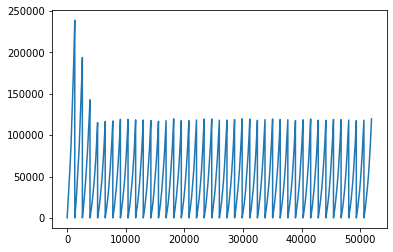

In [32]:
plt.plot(loss_trend)

In [33]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [34]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
ruler = EntityRuler(nlp).from_disk("patterns_2020_02_04.jsonl")
nlp.add_pipe(ruler, before='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
nlp.to_disk('trained_model_2020_02_04')

In [0]:
nlp = spacy.load('trained_model_2020_02_04')

In [0]:
ent_list_eval = []
for doc in nlp.pipe(eval_reviews['text']):
#  displacy.render(nlp(doc),'ent',jupyter=True)
  ent_list_eval.append([k  for k in Counter(sorted([(ent.ent_id_) for ent in doc.ents if ent.ent_id_ != ''])).keys()])
#ent_list.append([ent.text for ent in nlp(doc).ents if ent.ent_id_ == ''])

ent_list_eval[-5:]